# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
# first type of objective
# get the optimizer trace
objective_options = pypesto.ObjectiveOptions(trace_record=True, trace_save_iter=1)
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                               grad=sp.optimize.rosen_der, 
                               hess=sp.optimize.rosen_hess,
                               options=objective_options)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

## Illustration

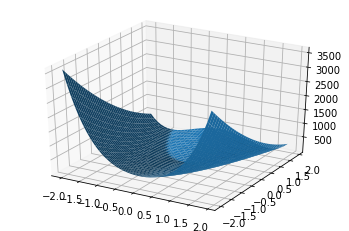

In [6]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)        

## Run optimization

In [3]:
# create different optimizers
optimizer_bfgs = pypesto.ScipyOptimizer(method='bfgs')
optimizer_tnc = pypesto.ScipyOptimizer(method='TNC')
optimizer_dogleg = pypesto.ScipyOptimizer(method='dogleg')

# set number of starts
n_starts = 20

# Run optimizaitons for different optimzers
result1_bfgs = pypesto.minimize(problem=problem1, optimizer=optimizer_bfgs, n_starts=n_starts)
result1_tnc = pypesto.minimize(problem=problem1, optimizer=optimizer_tnc, n_starts=n_starts)
result1_dogleg = pypesto.minimize(problem=problem1, optimizer=optimizer_dogleg, n_starts=n_starts)

# Optimize second type of objective
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer_tnc, n_starts=n_starts)

/usr/local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  RuntimeWarning)


/usr/local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  RuntimeWarning)


/usr/local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  RuntimeWarning)


/usr/local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method dogleg cannot handle constraints nor bounds.
  RuntimeWarning)


## Visualize and compare optimization results

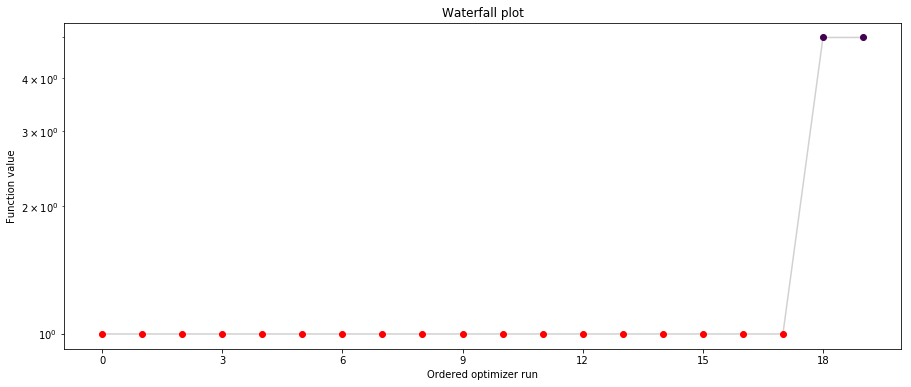

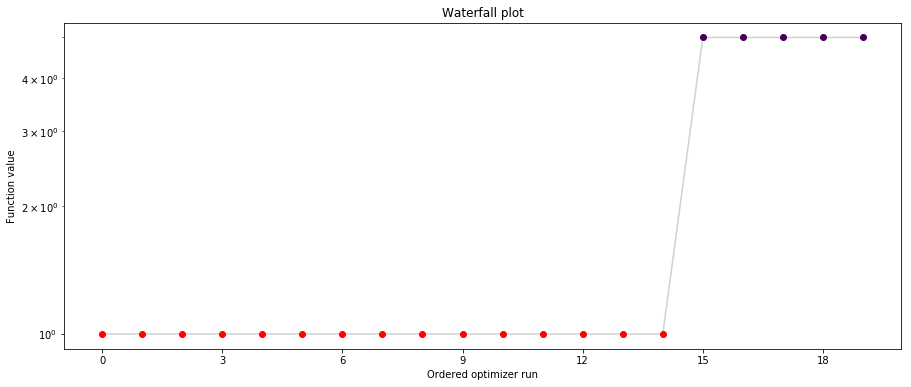

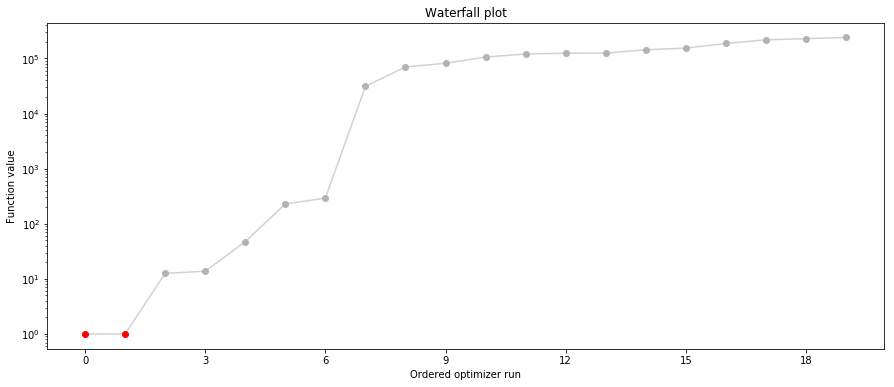

In [4]:
import pypesto.visualize

# plot separated waterfalls
pypesto.visualize.waterfall(result1_bfgs, size=(15,6))
pypesto.visualize.waterfall(result1_tnc, size=(15,6))
pypesto.visualize.waterfall(result1_dogleg, size=(15,6))

We can now have a closer look, which method perfomred better: Let's first compare bfgs and TNC, since both methods gave good results. How does they fine convergence look like?

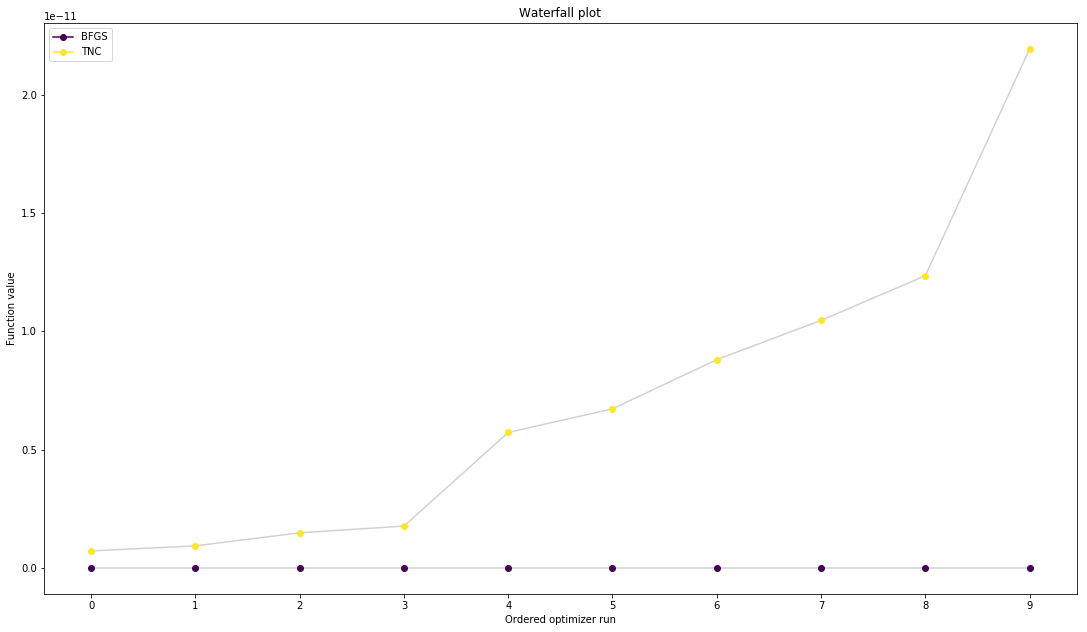

In [5]:
# plot one list of waterfalls
pypesto.visualize.waterfall([result1_bfgs, result1_tnc],
                            legends=['BFGS', 'TNC'],
                            start_indices=10,
                            scale_y='lin')

Second optimum at: 3.986579112347138


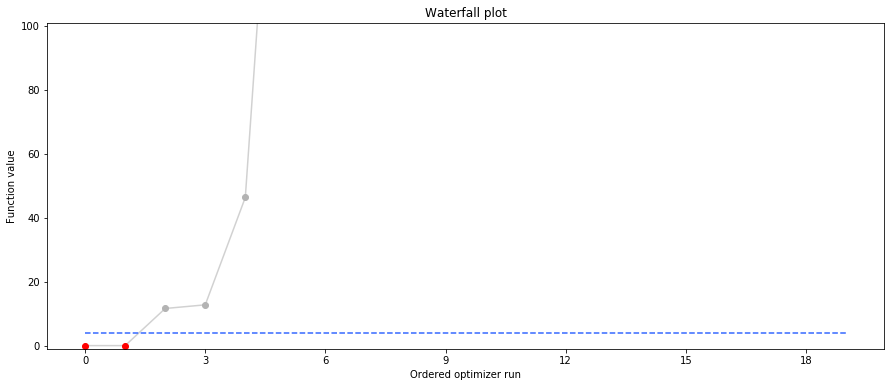

In [6]:
# retrieve second optimum
all_x = result1_bfgs.optimize_result.get_for_key('x')
all_fval = result1_bfgs.optimize_result.get_for_key('fval')
x = all_x[19]
fval = all_fval[19]
print('Second optimum at: ' + str(fval))

# create a reference point from it
ref = {'x': x, 'fval': fval, 'color': [
    0.2, 0.4, 1., 1.], 'legend': 'second optimum'}
ref = pypesto.visualize.create_references(ref)

# new waterfall plot with reference point for second optimum
pypesto.visualize.waterfall(result1_dogleg, size=(15,6), 
                            scale_y='lin', y_limits=[-1, 101],
                            reference=ref)

## Visualize parameters

There seems to be a second local optimum. We want to see whether it was also found by the dogleg method

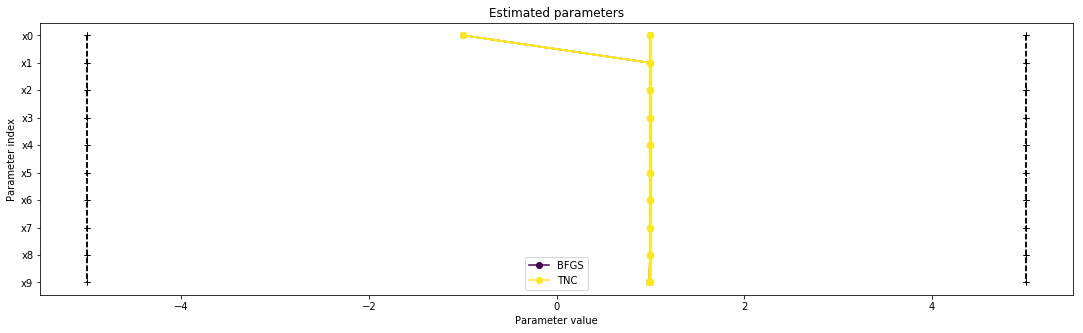

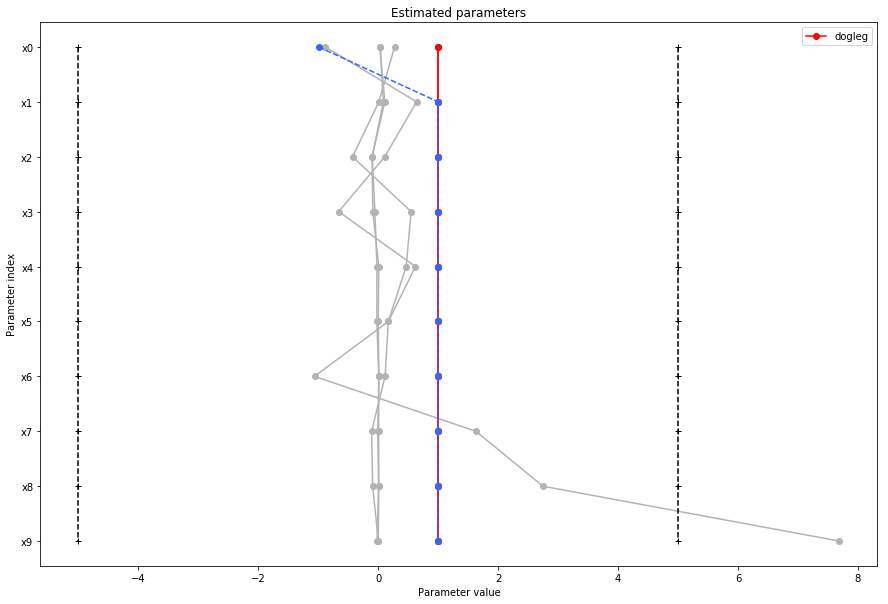

In [7]:
pypesto.visualize.parameters([result1_bfgs, result1_tnc],
                            legends=['BFGS', 'TNC'])
pypesto.visualize.parameters(result1_dogleg,
                             legends='dogleg',
                             reference=ref,
                             size=(15,10),
                             start_indices=[0, 1, 2, 3, 4, 5])

## Optimizer history

Let's compare optimzer progress over time.

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


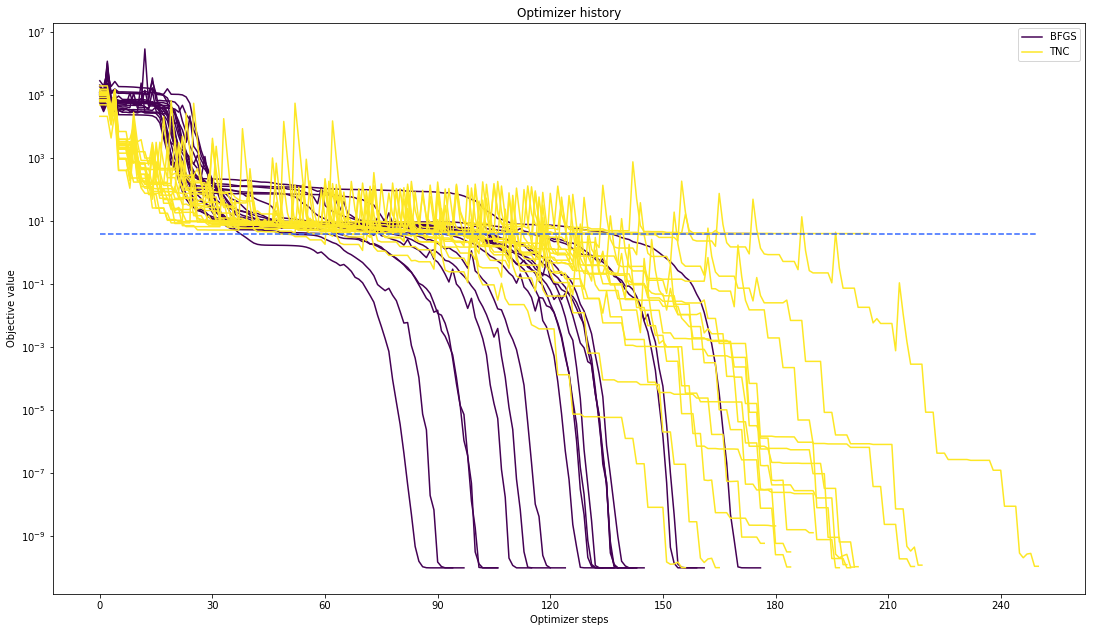

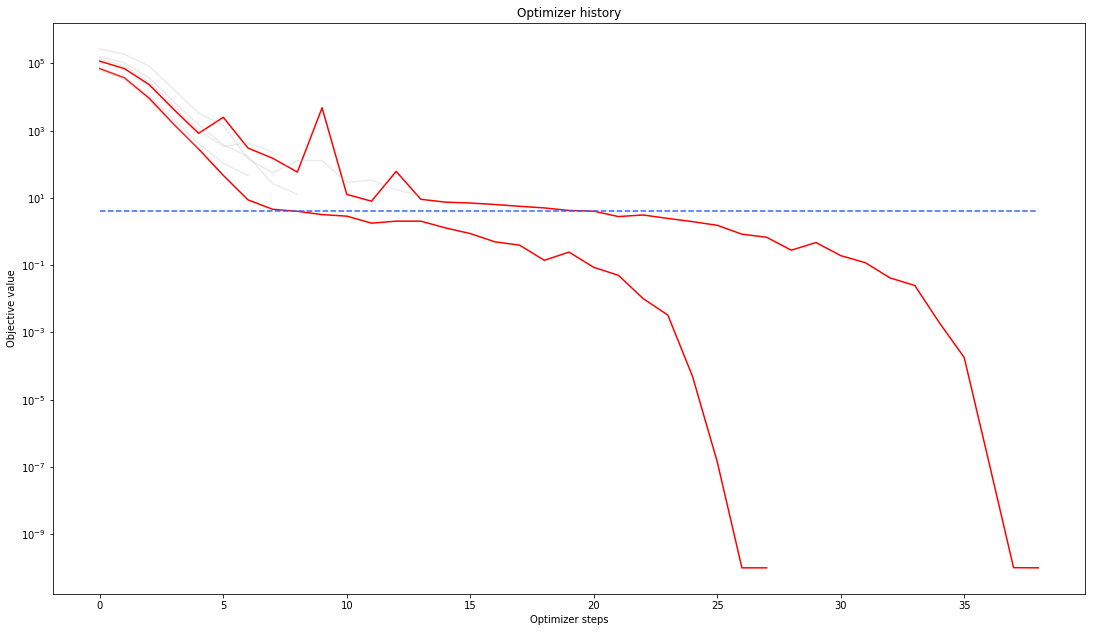

In [8]:
# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['BFGS', 'TNC'],
                                    reference=ref,
                                    offset_y=1e-10)
# plot one list of waterfalls
pypesto.visualize.optimizer_history(result1_dogleg,
                                    reference=ref,
                                    offset_y=1e-10)

## Compute profiles

The profiling routine needs a problem, a results object and an optimizer.

Moreover it accepts an index of integer (profile_index), whether or not a profile should be computed.

Finally, an integer (result_index) can be passed, in order to specify the local optimum, from which profiling should be started.

In [11]:

# compute profiles
profile_options = pypesto.ProfileOptions(min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005)

result1_tnc = pypesto.parameter_profile(
    problem=problem1,
    result=result1_tnc,
    optimizer=optimizer_tnc,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options)

# compute profiles from second optimum
result1_tnc = pypesto.parameter_profile(
    problem=problem1,
    result=result1_tnc,
    optimizer=optimizer_tnc,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=19,
    profile_options=profile_options)

## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

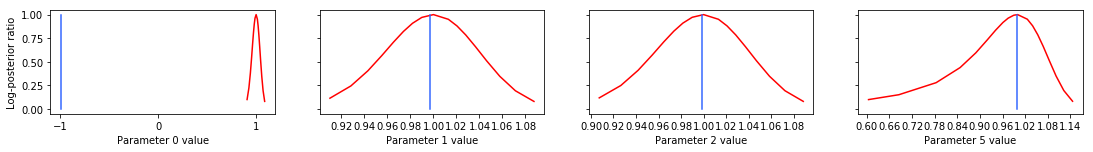

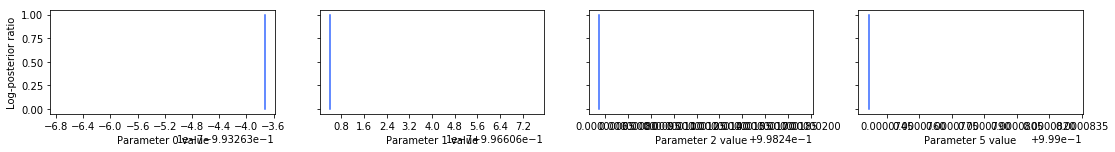

In [12]:
# specify the parameters, for which profiles should be computed
pypesto.visualize.profiles(result1_tnc, profile_indices = [0,1,2,5], 
                           reference=ref, profile_list=0)

# plor profiles again, now from second optimum
pypesto.visualize.profiles(result1_tnc, profile_indices = [0,1,2,5], 
                           reference=ref, profile_list=1)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [16]:
result1_tnc.optimize_result.as_dataframe(['fval', 'n_fval', 'n_grad', 
                                        'n_hess', 'n_res', 'n_sres', 'time'])

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,1.391997e-12,135,135,0,0,0,1.123281
1,1.712932e-12,173,173,0,0,0,1.450802
2,2.861706e-12,158,158,0,0,0,1.332778
3,3.191344e-12,235,235,0,0,0,1.980623
4,4.109782e-12,156,156,0,0,0,1.321207
5,5.021100e-12,231,231,0,0,0,2.116889
6,8.001508e-12,152,152,0,0,0,1.262909
7,1.636064e-11,203,203,0,0,0,1.926625
8,3.128886e-11,190,190,0,0,0,1.604168
9,6.478625e-11,222,222,0,0,0,1.858421
